# Capstone Project - The Battle of Neighbourhoods

## Business Problem

In this project, we are trying to address the business problem, "Which neighbourhood in Toronto is suitable to open a specific type of restaurant, in this case a Chinese Restaurant?" 
This project is particularly helpful for the entrepreneurs who are looking to open an Chinese restaurant in Toronto. It also helps food lovers to find a neighbourhood with most number of Chinese restaurants.

## Data Collection

### Neighbourhood Data

The list of Boroughs and Neighbourhoods of Toronto is obtained from wikipedia using web scraping techniques. 
Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [1]:
import pandas as pd
import numpy as np
import requests

In [2]:
!pip install wikipedia
import wikipedia as wp

Defaulting to user installation because normal site-packages is not writeable


In [54]:
webpage = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(webpage, header=0)[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [55]:
df['Neighbourhood'] = np.where(df.Neighbourhood == 'Not assigned', df.Borough, df.Neighbourhood)
df['Neighbourhood'] = df['Neighbourhood'].replace('Not assigned',np.nan)
df['Borough'] = df['Borough'].replace('Not assigned',np.nan)
df = df.dropna(axis=0, how='any', thresh=None, subset=None)
df = df.reset_index()
del df['index']
df_orig = df.copy()
df  = df.groupby(['Postcode', 'Borough']).agg({'Neighbourhood': lambda x: ','.join(tuple(x.tolist()))})
df = df.reset_index()
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Geographical Coordinates Data

In [5]:
!wget -O load_coordinates.csv http://cocl.us/Geospatial_data

--2020-02-26 17:47:06--  http://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 169.48.113.194, 158.85.108.83, 158.85.108.86
Connecting to cocl.us (cocl.us)|169.48.113.194|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cocl.us/Geospatial_data [following]
--2020-02-26 17:47:06--  https://cocl.us/Geospatial_data
Connecting to cocl.us (cocl.us)|169.48.113.194|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-26 17:47:08--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.24.197, 107.152.27.197, 107.152.29.197, ...
Connecting to ibm.box.com (ibm.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-26

In [6]:
df_coord = pd.read_csv('load_coordinates.csv')
df_coord.columns = ['Postcode','Latitude','Longitude']
df_final = pd.merge(df, df_coord, on='Postcode')
df_final = df_final.drop_duplicates()
df_final.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [7]:
print('Number of Broughs in the dataset: {} '.format(len(df_final['Borough'].unique())))
print('Number of Neighbourhoods in the dataset: {} '.format(len(df_final['Neighbourhood'].unique())))

Number of Broughs in the dataset: 10 
Number of Neighbourhoods in the dataset: 103 


### Get Neighbourhood populations

In [78]:
wikipage = wp.page("Demographics of Toronto neighbourhoods").html().encode("UTF-8")
df_pop = pd.read_html(wikipage, header = 0)[1]
df_pop = df_pop[['Name', 'Population']]
df_pop.columns = ["Neighbourhood", "Population"]
df_neigh_pop = pd.merge(df_orig, df_pop, on="Neighbourhood")
df_neigh_pop  = df_neigh_pop.groupby(['Postcode', 'Borough']).agg({'Neighbourhood': lambda x: ','.join(tuple(x.tolist())), 'Population': 'sum' })
df_neigh_pop

,,Neighbourhood,Population
Postcode,Borough,,
M1B,Scarborough,"Rouge,Malvern",67048
M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",36470
M1E,Scarborough,"Guildwood,Morningside,West Hill",49924
M1G,Scarborough,Woburn,48507
M1J,Scarborough,Scarborough Village,12796
M1K,Scarborough,Ionview,13025
M1L,Scarborough,"Clairlea,Oakridge",24472
M1M,Scarborough,"Cliffcrest,Cliffside",23917
M1N,Scarborough,Birch Cliff,12266


### Get Geocoordinates of Toronto using GeoPy

In [8]:
!pip install geopy
from geopy.geocoders import Nominatim

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import json
from pandas.io.json import json_normalize

In [10]:
city = 'Toronto'
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude
print("Latitude = {}, Longitude = {} ".format(latitude, longitude))

Latitude = 43.653963, Longitude = -79.387207 


### Get Venues in Toronto from FourSquare

In [11]:
# The code was removed by Watson Studio for sharing.

In [12]:
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT)
results = requests.get(url).json()

In [13]:
def get_categories(row):
    try:
        categories = row['categories']
    except:
        categories = row['venue.categories']

    if len(categories) == 0:
        return None
    else:
        return categories[0]['name']

In [14]:
column_list = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
items = results['response']['groups'][0]['items']

venues = json_normalize(items) 
venues =venues.loc[:, column_list]
venues['venue.categories'] = venues.apply(get_categories, axis=1)
venues.columns = [col.split(".")[-1] for col in venues.columns]
venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Karine's,Breakfast Spot,43.653699,-79.390743
3,Manpuku まんぷく,Japanese Restaurant,43.653612,-79.390613
4,Nathan Phillips Square,Plaza,43.652270,-79.383516


In [15]:
def getNeighbourVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    neighbour_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    neighbour_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(neighbour_venues)

In [16]:
LIMIT = 100
toronto_venues = getNeighbourVenues(names=df_final['Neighbourhood'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude']
                                  )

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

In [17]:
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [18]:
toronto_venues[toronto_venues['Venue Category']=='Chinese Restaurant']

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
47,"Dorset Park,Scarborough Town Centre,Wexford He...",43.757410,-79.273304,Kim Kim restaurant,43.753833,-79.276611,Chinese Restaurant
68,"Clarks Corners,Sullivan,Tam O'Shanter",43.781638,-79.304302,The Royal Chinese Restaurant 避風塘小炒,43.780505,-79.298844,Chinese Restaurant
82,L'Amoreaux West,43.799525,-79.318389,Mr Congee Chinese Cuisine 龍粥記,43.798879,-79.318335,Chinese Restaurant
83,L'Amoreaux West,43.799525,-79.318389,Phoenix Restaurant 金鳳餐廳,43.798198,-79.318432,Chinese Restaurant
158,"Fairview,Henry Farm,Oriole",43.778517,-79.346556,Manchu Wok,43.778225,-79.343302,Chinese Restaurant
165,Bayview Village,43.786947,-79.385975,Sun Star Chinese Cuisine 翠景小炒,43.787914,-79.381234,Chinese Restaurant
236,"Flemingdon Park,Don Mills South",43.725900,-79.340923,Congee Star 帝王名粥,43.726586,-79.341833,Chinese Restaurant
484,North Toronto West,43.715383,-79.405678,C'est Bon,43.716785,-79.400406,Chinese Restaurant
597,"Cabbagetown,St. James Town",43.667967,-79.367675,China Gourmet,43.664180,-79.368359,Chinese Restaurant
598,"Cabbagetown,St. James Town",43.667967,-79.367675,Tender Trap Restaurant,43.667724,-79.369485,Chinese Restaurant


## Data Analysis

In [19]:
!pip install folium
import folium

Defaulting to user installation because normal site-packages is not writeable


### Plot Neighbourhoods on Map

In [20]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighbourhood in zip(df_final['Latitude'], df_final['Longitude'], df_final['Borough'], df_final['Neighbourhood']):
    label = '{},{}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [21]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']
cols = toronto_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighbourhood')))
toronto_onehot = toronto_onehot.reindex(columns= cols)

toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.1,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,"Alderwood,Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0


In [22]:
toronto_subset = toronto_grouped[['Neighbourhood', 'Chinese Restaurant']]
toronto_subset

,Neighbourhood,Chinese Restaurant
0,"Adelaide,King,Richmond",0.0
1,Agincourt,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0
4,"Alderwood,Long Branch",0.0
...,...,...
94,Willowdale West,0.0
95,Woburn,0.0
96,"Woodbine Gardens,Parkview Hill",0.0
97,Woodbine Heights,0.0


In [23]:
toronto_merged = pd.merge(df_final, toronto_subset, on='Neighbourhood')
toronto_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Chinese Restaurant
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0.000
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0.000
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0.000
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.000
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.000
...,...,...,...,...,...,...
94,M9N,York,Weston,43.706876,-79.518188,0.000
95,M9P,Etobicoke,Westmount,43.696319,-79.532242,0.125
96,M9R,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie...",43.688905,-79.554724,0.000
97,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739416,-79.588437,0.000


### Boroughs with Chinese Restaurants

In [27]:
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df_chinese_rest = toronto_venues[toronto_venues['Venue Category']=='Chinese Restaurant']
df_boro_chinese = pd.merge(df_final, df_chinese_rest, on='Neighbourhood', how='left')
df_boro_chinese = df_boro_chinese[['Borough','Venue']].groupby(['Borough']).agg(['count'])
df_boro_chinese

,Venue
,count
Borough,
Central Toronto,1
Downtown Toronto,13
East Toronto,0
East York,0
Etobicoke,1
Mississauga,0
North York,3
Scarborough,4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


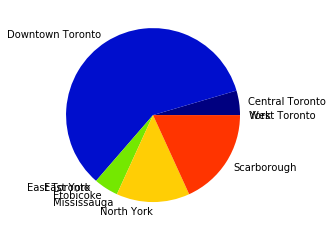

In [29]:
a=np.random.random(10)
cs=cm.gist_ncar(np.arange(10)/10.)

plt.pie(x=df_boro_chinese["Venue"], labels=df_boro_chinese.index, colors=cs)
plt.show()

In [30]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


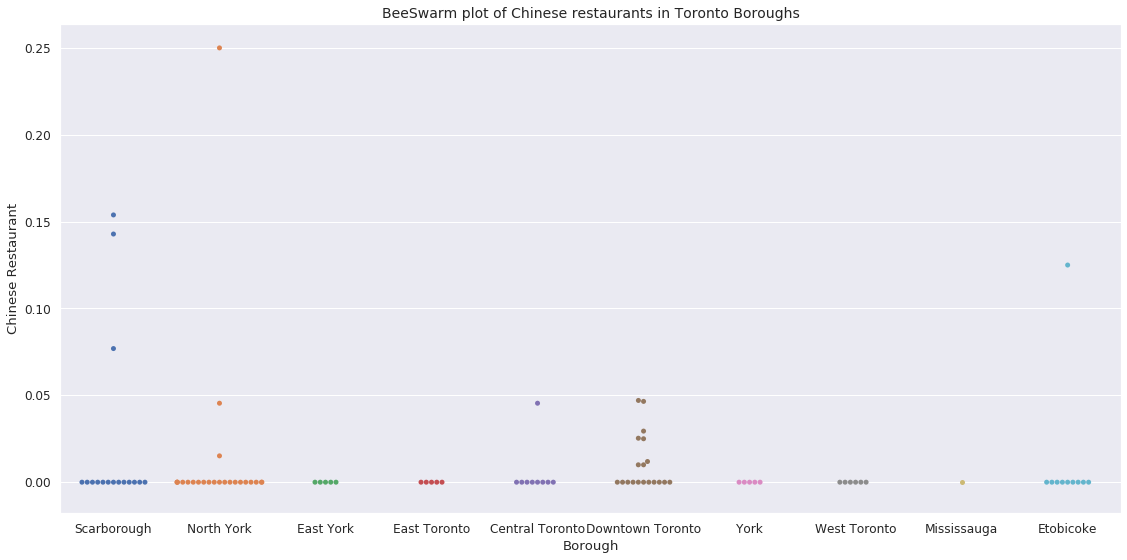

In [31]:
fig = plt.figure(figsize=(19,9))

sns.set(font_scale=1.1)
sns.swarmplot(y="Chinese Restaurant", x="Borough", data=toronto_merged);

plt.title('BeeSwarm plot of Chinese restaurants in Toronto Boroughs', fontsize=14)
plt.show()

### Neighbourhoods with Chinese Restaurants

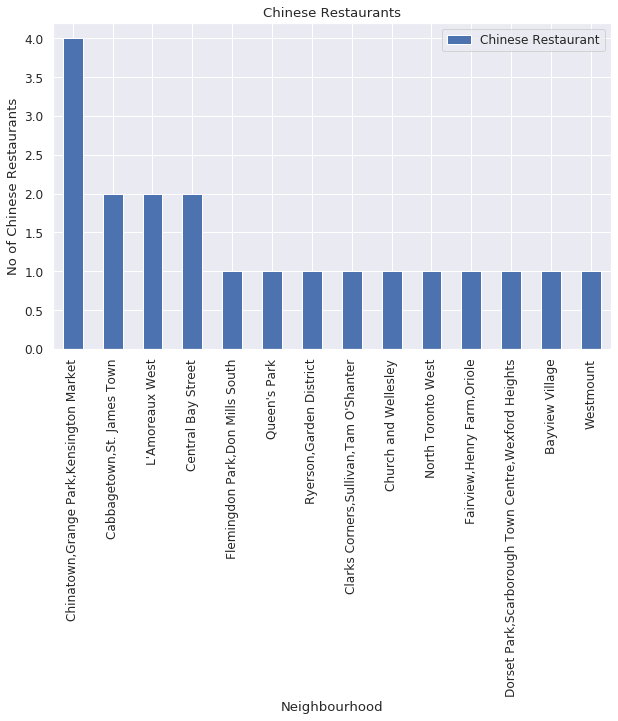

In [32]:
graph = pd.DataFrame(toronto_onehot.groupby('Neighbourhood')['Chinese Restaurant'].sum())
graph = graph.sort_values(by ='Chinese Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighbourhood")
plt.ylabel("No of Chinese Restaurants")
plt.title("Chinese Restaurants")
plt.show()

## Data Modeling

### K-Means Clusteing of Neighbourhoods

In [33]:
!pip install scikit-learn
from sklearn.cluster import KMeans

Defaulting to user installation because normal site-packages is not writeable


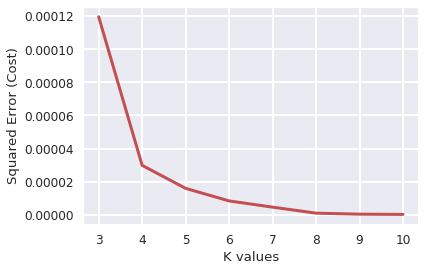

In [34]:
toronto_clustering = toronto_subset.drop('Neighbourhood', 1)
error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_clustering)
    except ValueError:
        print("error: ",i)
        
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

In [35]:
from yellowbrick.cluster import KElbowVisualizer

/home/shyju/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


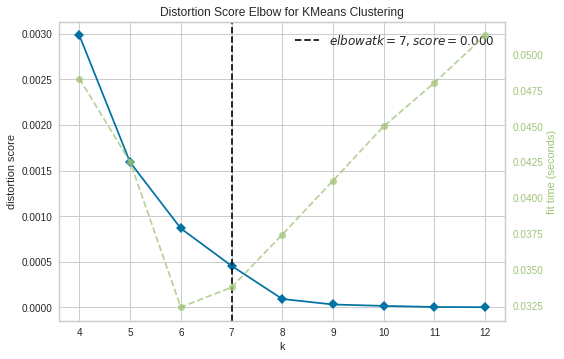

In [36]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))
visualizer.fit(toronto_clustering)        
visualizer.show()  

In [37]:
# Clustering the Toronto Neighborhood Using K-Means with K = 7
kclusters = 7
toronto_clustering = toronto_subset.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [38]:
toronto_subset.insert(0, 'Cluster', kmeans.labels_)
toronto_subset

,Cluster,Neighbourhood,Chinese Restaurant
0,3,"Adelaide,King,Richmond",0.0
1,3,Agincourt,0.0
2,3,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0
3,3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0
4,3,"Alderwood,Long Branch",0.0
...,...,...,...
94,3,Willowdale West,0.0
95,3,Woburn,0.0
96,3,"Woodbine Gardens,Parkview Hill",0.0
97,3,Woodbine Heights,0.0


In [39]:
toronto_merged = pd.merge(df_final, toronto_subset, on='Neighbourhood')
toronto_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,Chinese Restaurant
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,3,0.000
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,3,0.000
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,3,0.000
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,0.000
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,0.000
...,...,...,...,...,...,...,...
94,M9N,York,Weston,43.706876,-79.518188,3,0.000
95,M9P,Etobicoke,Westmount,43.696319,-79.532242,1,0.125
96,M9R,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie...",43.688905,-79.554724,3,0.000
97,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739416,-79.588437,3,0.000


In [40]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.Set1(np.linspace(0, 1, len(ys)))
Set1 = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=Set1[cluster-1],
        fill=True,
        fill_color=Set1[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

### Cluster Analysis

In [41]:
# Cluster 0:
toronto_merged.loc[toronto_merged['Cluster'] == 0]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,Chinese Restaurant
17,M2J,North York,"Fairview,Henry Farm,Oriole",43.778517,-79.346556,0,0.015152
50,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,0.011905
52,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937,0,0.010000
57,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,0,0.010000


In [42]:
# Cluster 1: 
toronto_merged.loc[toronto_merged['Cluster'] == 1]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,Chinese Restaurant
10,M1P,Scarborough,"Dorset Park,Scarborough Town Centre,Wexford He...",43.757410,-79.273304,1,0.142857
15,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,1,0.153846
95,M9P,Etobicoke,Westmount,43.696319,-79.532242,1,0.125000


In [43]:
# Cluster 2: 
toronto_merged.loc[toronto_merged['Cluster'] == 2]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,Chinese Restaurant
18,M2K,North York,Bayview Village,43.786947,-79.385975,2,0.25


In [44]:
# Cluster 3: 
toronto_merged.loc[toronto_merged['Cluster'] == 3]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,Chinese Restaurant
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,3,0.0
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,3,0.0
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,3,0.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,0.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,0.0
...,...,...,...,...,...,...,...
93,M9M,North York,"Emery,Humberlea",43.724766,-79.532242,3,0.0
94,M9N,York,Weston,43.706876,-79.518188,3,0.0
96,M9R,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie...",43.688905,-79.554724,3,0.0
97,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739416,-79.588437,3,0.0


In [45]:
# Cluster 4: 
toronto_merged.loc[toronto_merged['Cluster'] == 4]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,Chinese Restaurant
25,M3C,North York,"Flemingdon Park,Don Mills South",43.725900,-79.340923,4,0.045455
44,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,4,0.045455
49,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,4,0.046512
65,M5T,Downtown Toronto,"Chinatown,Grange Park,Kensington Market",43.653206,-79.400049,4,0.047059


In [46]:
# Cluster 5: 
toronto_merged.loc[toronto_merged['Cluster'] == 5]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,Chinese Restaurant
13,M1T,Scarborough,"Clarks Corners,Sullivan,Tam O'Shanter",43.781638,-79.304302,5,0.076923


In [47]:
# Cluster 6: 
toronto_merged.loc[toronto_merged['Cluster'] == 6]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,Chinese Restaurant
55,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,6,0.025316
64,M5S,Downtown Toronto,"Harbord,University of Toronto",43.662696,-79.400049,6,0.029412
83,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,6,0.025000


### Cluster 3 population

In [80]:
df_favourable = toronto_merged.loc[toronto_merged['Cluster'] == 3]
df_fav_pop = pd.merge(df_favourable, df_neigh_pop, on='Postcode')
df_fav_pop.sort_values(by=['Population'], ascending=False).head()

,Postcode,Borough,Neighbourhood_x,Latitude,Longitude,Cluster,Chinese Restaurant,Neighbourhood_y,Population
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,3,0.0,"Rouge,Malvern",67048
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,3,0.0,"Guildwood,Morningside,West Hill",49924
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,0.0,Woburn,48507
10,M1S,Scarborough,Agincourt,43.794200,-79.262029,3,0.0,Agincourt,44577
34,M6R,West Toronto,"Parkdale,Roncesvalles",43.648960,-79.456325,3,0.0,"Parkdale,Roncesvalles",44363


## Results

1. From the K Means Clustering we could infer that the neighbourhoods in cluster 3 has no or less number of chinese restaurants. 
2. From the Bee Swarm plot and pie chart of boroughs we could deduce that there are higher density of Chinese restaurants located in the Downtown Toronto and very few in Mississauga.
3. Neighbourhoods in cluster 3 from Boroughs East Toronto, West Toronto, East York, York and Mississauga Boroughs have no Chinese restaurants.
4. In Cluster 3, neighbourhoods Rouge & Malvern in Scarborough have the largest population and since there are no Chinese Restaurants at these neighbourhoods, they are suitable for opening a new restaurant.